In [43]:
import pandas as pd
from tqdm import tqdm
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde, binned_statistic_dd
from mpl_toolkits.mplot3d import Axes3D

In [44]:
file = "../data/SSCURVES.xlsx"

In [45]:
def logistic(x, a, k, xc):
    return a/(1 + np.exp(-k*(x-xc)))

In [46]:
def r2_fn(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    
    return r2

  6%|████                                                            | 4/63 [00:00<00:03, 18.14it/s]

Only curves belonging to thigh are included. Excluding 1
Only curves belonging to thigh are included. Excluding 1
Only curves belonging to thigh are included. Excluding 2
Only curves belonging to thigh are included. Excluding 2


 10%|██████                                                          | 6/63 [00:00<00:03, 15.05it/s]

Only curves belonging to thigh are included. Excluding 3


100%|███████████████████████████████████████████████████████████████| 63/63 [00:07<00:00,  8.43it/s]


No person id information found for 62
No person id information found for 555
    index          a          k        xc        r2  person_id
0       6  11.907112  23.358183  1.343536  0.998290          4
1       7   7.626809  25.646122  1.473007  0.999788          5
2       8   4.642277  23.513952  1.472741  0.999895          6
3       9   7.959597  19.331536  1.331278  0.998797          6
4      10   3.309715  28.963632  1.201851  0.996660          7
5      11   5.994179  23.651890  1.179996  0.994457          8
6      12   3.663657  21.963652  1.265844  0.999329          9
7      13   2.427453  17.765873  1.289461  0.998854         10
8      14   3.146789  46.671645  1.402187  0.998000         11
9      15  14.306805  26.773711  1.185899  0.999180         12
10     16   4.064649  29.401408  1.321485  0.996641         13
11     17   3.485572  24.474050  1.217597  0.998983         13
12     18   3.301961  23.380835  1.235641  0.998955         13
13     19   2.950224  21.643259  1.227979

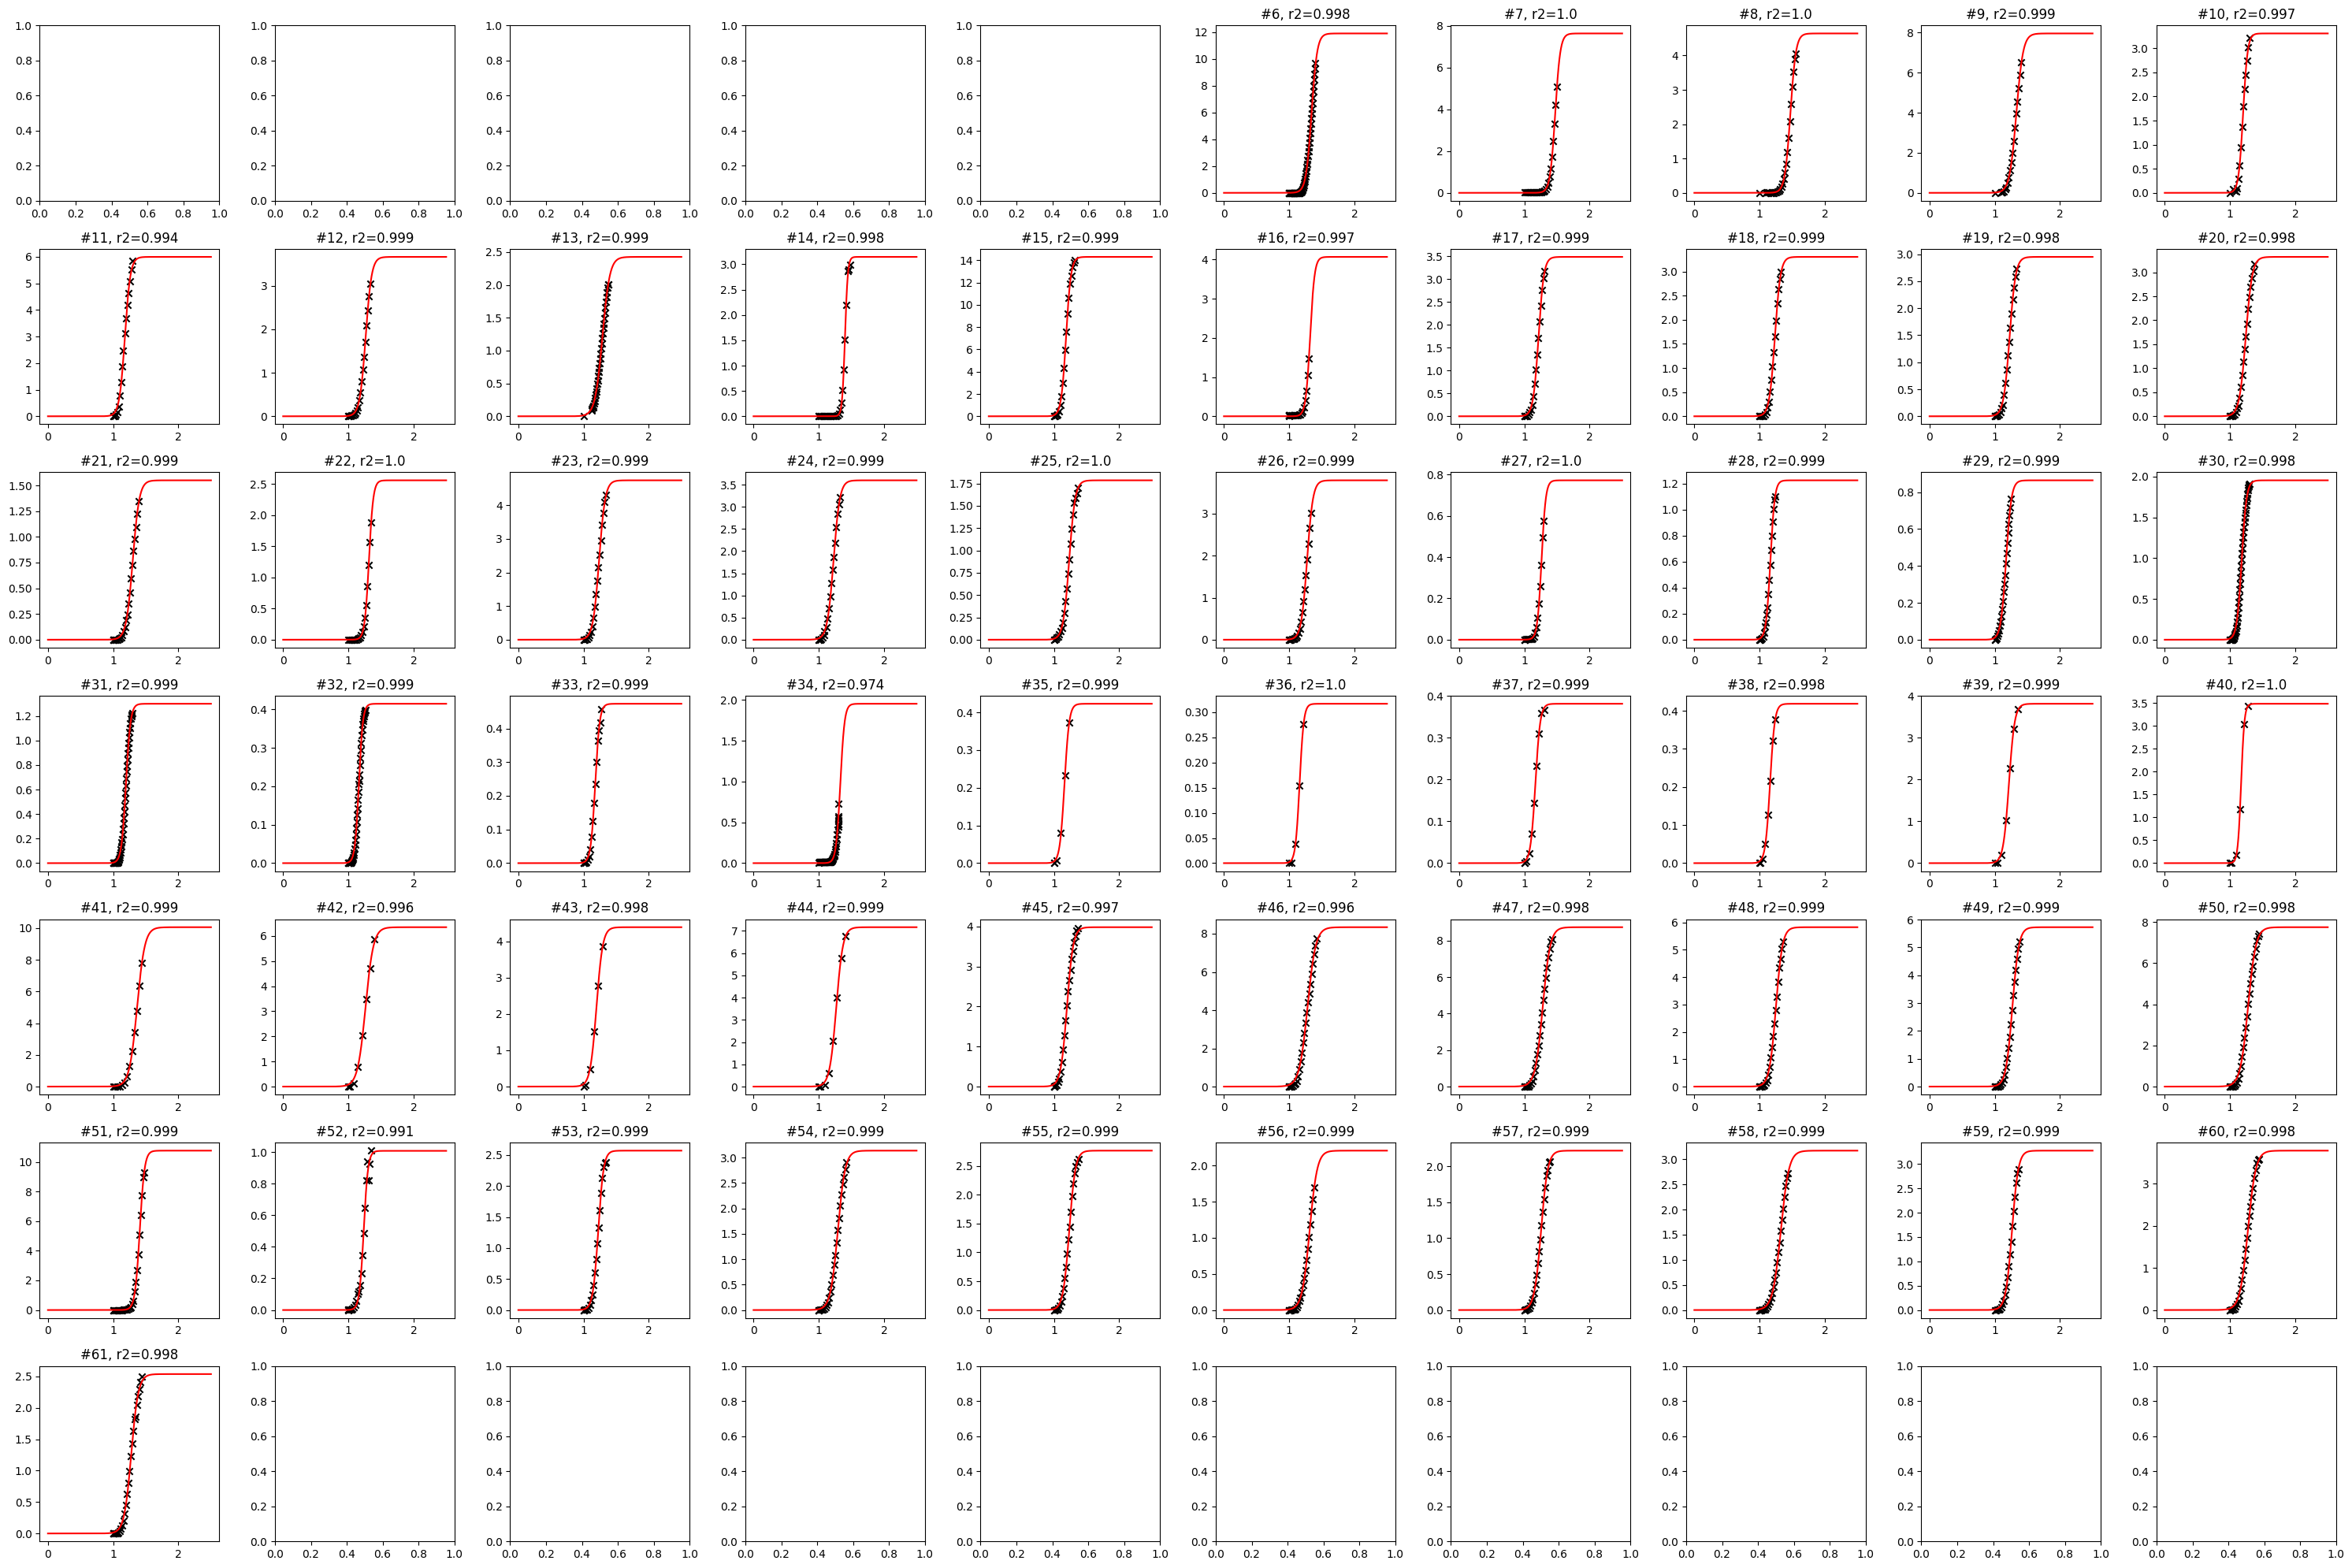

In [47]:
xls = pd.ExcelFile(file)

index_list =  []
person_ids = []
a_list = []
k_list = []
xc_list = []

r2_list = []

fig, axs = plt.subplots(7, 10, figsize=(30,20))
x = np.linspace(0, 2.5, 1000)


for sheet, ax in tqdm(zip(xls.sheet_names, axs.flat), total=len(xls.sheet_names), ncols=100):
    df = pd.read_excel(file, sheet_name=sheet)

    try:
        person_id = int(df['id'].iloc[0])
        type = str(df['type'].iloc[0])
    except KeyError:
        print(f"No person id information found for {sheet}")
        person_id = None
        continue

    valid_type = 'thigh'
    if type != valid_type:
        print(f"Only curves belonging to {valid_type} are included. Excluding {person_id}")
        continue

    person_ids.append(person_id)

    df = df.groupby(["Strain"], as_index=False).agg({'Stress': 'mean'})
    df = df.sort_values("Strain")

    x_data = df['Strain']
    y_data = df['Stress']

    popt, _ = curve_fit(logistic, x_data, y_data, bounds=((0, -np.inf, -np.inf), (np.inf, np.inf, np.inf)), maxfev=10000)#bounds=((0, -np.inf,-np.inf,0),(np.inf, np.inf, np.inf,np.inf)), maxfev=10000)
    index_list.append(int(sheet))
    a_list.append(popt[0])
    k_list.append(popt[1])
    xc_list.append(popt[2])

    r2 = r2_fn(y_data, logistic(x_data, *popt))
    r2_list.append(r2)

    ax.scatter(x_data, y_data, marker='x', color='black')
    ax.plot(x, logistic(x, *popt), 'r-')
    ax.set_title(f"#{sheet}, r2={round(r2, 3)}")


data = {
    "index": index_list,

    "a": a_list,
    "k": k_list,
    "xc": xc_list,
    "r2": r2_list,
    "person_id": person_ids,
}

df = pd.DataFrame.from_dict(data)
print(df)

plt.tight_layout()
plt.savefig("outputs/logistic_fits.png")
plt.show()


In [48]:
df.to_csv("outputs/logistic_targets.csv", index=False) # We have our own indices.

array([[<AxesSubplot: title={'center': 'person_id'}>]], dtype=object)

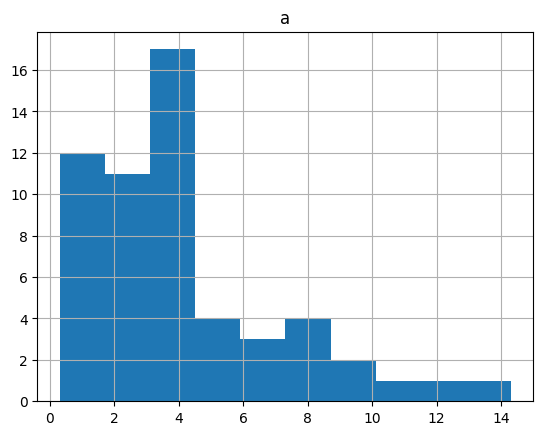

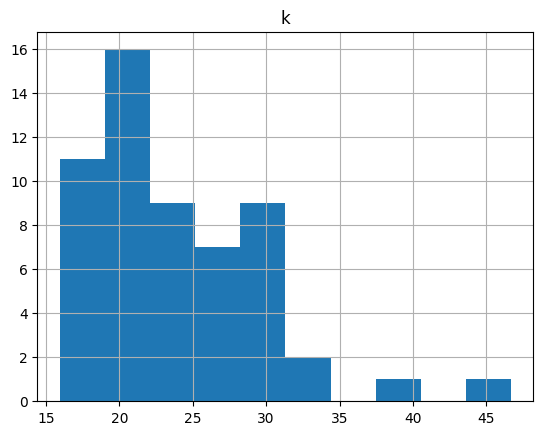

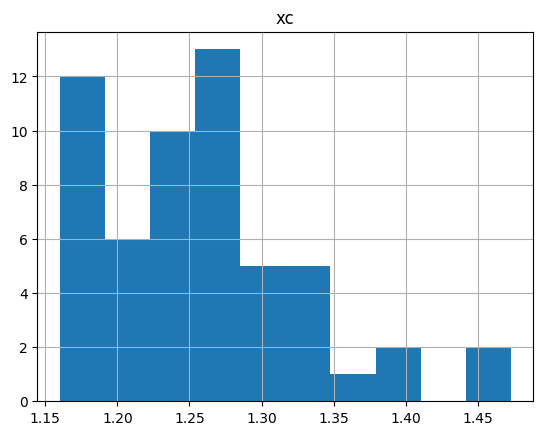

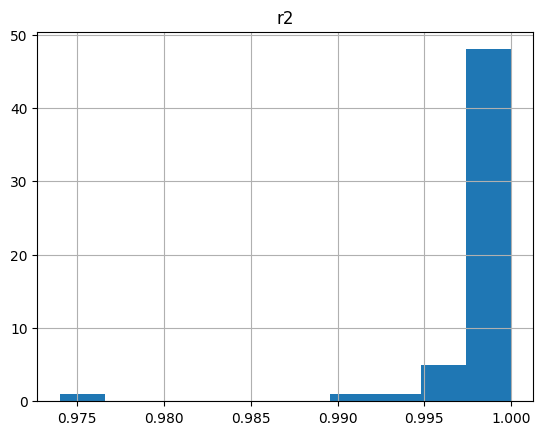

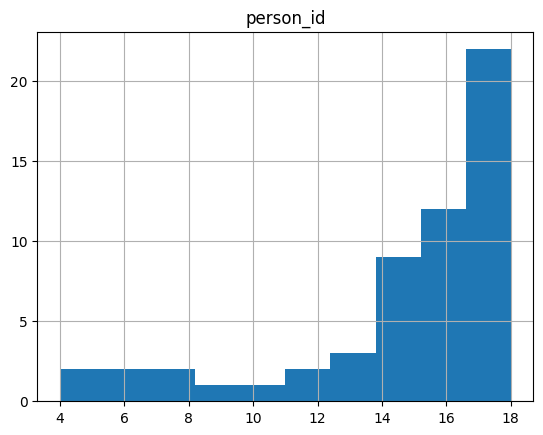

In [49]:
df.hist(column='a')
df.hist(column='k')
df.hist(column='xc')
df.hist(column='r2')
df.hist(column='person_id')